In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

# Uncomment the follwing line to enabled devlib debugging statements
# logging.getLogger('ssh').setLevel(logging.DEBUG)

2017-09-05 15:03:18,724 INFO    : root         : Using LISA logging configuration:
2017-09-05 15:03:18,725 INFO    : root         :   /home/lisa/lisa-github/logging.conf


In [2]:
# Generate plots inline
%pylab inline

import copy
import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },

    # Define devlib module to load
    "modules"     : [
        'bl',           # enable big.LITTLE support
        'cpufreq'       # enable CPUFreq support
    ],


}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Additional devlib modules required for this experiment
    "modules" : ['hwmon'],
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_switch",
             "sched_load_avg_cpu",
             "cpu_frequency",
             "cpu_capacity"
         ],
         "buffsize" : 10240
    },

}

In [4]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2017-09-05 15:03:24,185 INFO    : TestEnv      : Using base path: /home/lisa/lisa-github
2017-09-05 15:03:24,187 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-09-05 15:03:24,189 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-09-05 15:03:24,190 INFO    : TestEnv      : External tools using:
2017-09-05 15:03:24,191 INFO    : TestEnv      :    ANDROID_HOME: /home/lisa/android-sdk
2017-09-05 15:03:24,193 INFO    : TestEnv      :    CATAPULT_HOME: /home/lisa/lisa-github/tools/catapult
2017-09-05 15:03:24,194 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq', 'hwmon']
2017-09-05 15:03:24,195 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2017-09-05 15:03:24,196 INFO    : TestEnv      : Connection settings:
2017-09-05 15:03:24,197 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2017-09-05 15:03:24,782 INFO    : TestEnv      : Initializing target workdir:
2017-09-05 15:03:24,783 

In [5]:
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

2017-09-05 15:03:30,899 INFO    : root         : Target ABI: arm64, CPus: ['A53', 'A53', 'A53', 'A53', 'A73', 'A73', 'A73', 'A73']


# Support functions

These are a set of functions to run a workload with different CPUFreq configurations

In [6]:
def set_performance():
    target.cpufreq.set_all_governors('performance')

def set_powersave():
    target.cpufreq.set_all_governors('powersave')

def set_interactive():
    target.cpufreq.set_all_governors('interactive')

def set_sched():
    target.cpufreq.set_all_governors('sched')

def set_ondemand():
    target.cpufreq.set_all_governors('ondemand')
    
    # Configure the MAX sampling rate supporte by the LITTLE cores
    littles_tunables = target.cpufreq.get_governor_tunables(
                            target.bl.littles[0])
    target.cpufreq.set_governor_tunables(
        target.bl.littles[0], 'ondemand',
        **{'sampling_rate' : littles_tunables['sampling_rate_min']}
    )
    
    # Configure the MAX sampling rate supporte by the big cores
    bigs_tunables = target.cpufreq.get_governor_tunables(
                            target.bl.bigs[0])
    target.cpufreq.set_governor_tunables(
        target.bl.bigs[0], 'ondemand',
        **{'sampling_rate' : bigs_tunables['sampling_rate_min']}
    )
    

In [7]:
# CPUFreq configurations to test
confs = {
    'performance' : {
        'label' : 'prf',
        'set' :  set_performance,
    },
#     'powersave' : {
#         'label' : 'pws',
#         'set' :  set_powersave,
#     },
    'interactive' : {
        'label' : 'int',
        'set' :  set_interactive,
    },
    'sched' : {
        'label' : 'sch',
        'set' :  set_sched,
    },
#     'ondemand' : {
#         'label' : 'odm',
#         'set' :  set_ondemand,
#     }
}

# The set of results forlder for each comparition test
results = {}

In [8]:
def experiment(governor, rtapp, exp_dir):
    os.system('mkdir -p {}'.format(exp_dir));

    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    confs[governor]['set']()

    # Start FTrace and Energy monitoring
    te.ftrace.start()
    te.emeter.reset()
    
    # Run the workload
    rtapp.run(out_dir=exp_dir)
    
    # Stop FTrace and sample Energy consumption
    nrg = te.emeter.report(exp_dir).channels
    te.ftrace.stop()
    
    logging.info('Energy: %s', nrg)
    
    # Dump platform description
    te.platform_dump(exp_dir)
    
    # Collect and keep track of the trace
    trace_file = os.path.join(exp_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Parse trace
    tr = Trace(te.platform, exp_dir,
               events=my_tests_conf['ftrace']['events'])
    
    # return all the experiment data
    return {
        'dir'      : exp_dir,
        'energy'   : copy.deepcopy(nrg),
        'trace'    : trace_file,
        'tr'       : tr,
        'ftrace'   : tr.ftrace
    }

    
def compare(tid, rtapp):    
    logging.info('Test case: %s', tid)
    
    res_dir = os.path.join(te.res_dir, tid)
    logging.info('  results folder: %s', res_dir)
    
    # Run the workload in all the configured governors
    results[tid] = {}
    for governor in confs:
        test_dir = os.path.join(res_dir, governor)
        results[tid][governor] = experiment(governor, rtapp, test_dir)
        
def plot(tid):
    global results
    
    for governor in confs:
        plot_title = "{} Governor".format(governor.upper())
        trappy.LinePlot(results[tid][governor]['ftrace'],
                        templates,
                        column=column,
                        pivot="cpu",
                        filters={"cpu": [4]},
                        marker = '+',
                        drawstyle='steps-post',
                        title=plot_title,
                        ylim=(0, 1100)).view()
        
    for governor in confs:
        pa = PerfAnalysis(results[tid][governor]['dir'])
        for task in pa.tasks():
            pa.plotPerf(task, "Performance using [{}] governor"\
                                .format(governor))
        
def report_nrg(tid):
    global results
    
    print "{:15s} |  {:>9s}"\
        .format('Governor', 'Total')
    print "{:-<16s}+{:-<30s}".format('', '')
    for governor in confs:
        plot_title = "{}".format(governor.upper())
        nrg = results[tid][governor]['energy']
        nrg_sum = float(nrg['Device1'])
#         nrg_big = float(nrg['big'])
#         nrg_sum = nrg_little + nrg_big
        print "{:15s} |  {:9.3f}"\
            .format(governor,  nrg_sum)

# Test: light/heavy/light

In [9]:
# Define a label for this test case
test_case = 'light-heavy-light'

light1 = Periodic(duty_cycle_pct=10, duration_s=1.0, period_ms= 10,
                  cpus=str(target.bl.bigs_online[0]))
heavy1 = Periodic(duty_cycle_pct=90, duration_s=0.1, period_ms=100)
light2 = Periodic(duty_cycle_pct=10, duration_s=1.0, period_ms= 10)

lhl_task = light1 + heavy1 + light2

rtapp = RTA(target, 'smoke', calibration=te.calibration())
rtapp.conf(
    kind='profile',
    params={
        'task1' : lhl_task.get()
    },
    run_dir=target.working_directory
);

2017-09-05 15:03:40,393 INFO    : Workload     : Setup new workload smoke
2017-09-05 15:03:40,451 INFO    : Workload     : Workload duration defined by longest task
2017-09-05 15:03:40,453 INFO    : Workload     : Default policy: SCHED_OTHER
2017-09-05 15:03:40,454 INFO    : Workload     : ------------------------
2017-09-05 15:03:40,455 INFO    : Workload     : task [task1], sched: using default policy
2017-09-05 15:03:40,455 INFO    : Workload     :  | loops count: 1
2017-09-05 15:03:40,457 INFO    : Workload     :  | CPUs affinity: 4
2017-09-05 15:03:40,458 INFO    : Workload     : + phase_000001: duration 1.000000 [s] (100 loops)
2017-09-05 15:03:40,459 INFO    : Workload     : |  period    10000 [us], duty_cycle  10 %
2017-09-05 15:03:40,460 INFO    : Workload     : |  run_time   1000 [us], sleep_time   9000 [us]
2017-09-05 15:03:40,461 INFO    : Workload     : + phase_000002: duration 0.100000 [s] (1 loops)
2017-09-05 15:03:40,462 INFO    : Workload     : |  period   100000 [us],

In [10]:
# Run this workload in all the configurations
compare(test_case, rtapp)

2017-09-05 15:03:51,021 INFO    : root         : Test case: light-heavy-light
2017-09-05 15:03:51,024 INFO    : root         :   results folder: /home/lisa/lisa-github/results/20170905_150324/light-heavy-light
2017-09-05 15:03:51,033 INFO    : root         : ------------------------
2017-09-05 15:03:51,035 INFO    : root         : Run workload using performance governor


2017-09-05 15:03:54,365 INFO    : Workload     : Workload execution START:
2017-09-05 15:03:54,366 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/smoke_00.json 2>&1
2017-09-05 15:04:00,199 INFO    : root         : Energy: {'Device1': 17921.71, 'Device0': 0.0}
2017-09-05 15:04:02,650 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2017-09-05 15:04:02,664 INFO    : root         : ------------------------
2017-09-05 15:04:02,665 INFO    : root         : Run workload using sched governor


2017-09-05 15:04:06,134 INFO    : Workload     : Workload execution START:
2017-09-05 15:04:06,135 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/smoke_00.json 2>&1
2017-09-05 15:04:12,023 INFO    : root         : Energy: {'Device1': 13800.88, 'Device0': 0.0}
2017-09-05 15:04:14,284 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2017-09-05 15:04:14,297 INFO    : root         : ------------------------
2017-09-05 15:04:14,299 INFO    : root         : Run workload using interactive governor


2017-09-05 15:04:17,560 INFO    : Workload     : Workload execution START:
2017-09-05 15:04:17,562 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/smoke_00.json 2>&1
2017-09-05 15:04:23,422 INFO    : root         : Energy: {'Device1': 13285.09, 'Device0': 0.0}
2017-09-05 15:04:25,606 INFO    : Trace        : Platform clusters verified to be Frequency coherent


In [13]:
# Plot all data collected from experiments
def plot(tid):
    global results
    
    # Plot CPU LoadAvg and Capacity (for CPU0)
    for governor in confs:
        plot_title = "{} Governor".format(governor.upper())
        trappy.LinePlot(results[tid][governor]['ftrace'],
                        signals=[
                            "sched_load_avg_cpu:util_avg",
                            "cpu_capacity:capacity"],
                        pivot="cpu",
                        filters={"cpu": [4]},
                        marker = '+',
                        drawstyle='steps-post',
                        title=plot_title,
                        ylim=(0, 1100)).view()
    
    # Plot Custer Frequencies and report averate frequencies
    for governor in confs:
        plot_title = "Cluster frequencies, {}".format(governor.upper())
        trace = results[tid][governor]['tr']
        logging.info("%s:", plot_title)
        trace.analysis.frequency.plotClusterFrequencies(title=plot_title)
    
    # Plot RTApp performance index
    for governor in confs:
        plot_title = "RTApp performances, {}".format(governor.upper())
        pa = PerfAnalysis(results[tid][governor]['dir'])
        logging.info("%s:", plot_title)
        for task in pa.tasks():
            pa.plotPerf(task, "Performance using [{}] governor"\
                                .format(governor))
            

2017-09-05 15:10:32,878 INFO    : root         : Cluster frequencies, PERFORMANCE:
2017-09-05 15:10:33,042 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-09-05 15:10:33,078 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-09-05 15:10:33,512 INFO    : Analysis     : LITTLE cluster average frequency: 1.844 GHz
2017-09-05 15:10:33,514 INFO    : Analysis     : big    cluster average frequency: 2.362 GHz
2017-09-05 15:10:33,515 INFO    : root         : Cluster frequencies, SCHED:
2017-09-05 15:10:33,678 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-09-05 15:10:33,717 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-09-05 15:10:34,149 INFO    : Analysis     : LITTLE cluster average frequency: 1.042 GHz
2017-09-05 15:10:34,153 INFO    : Analysis     : big    cluster average frequency: 0.955 GHz
2017-09-05 15:10:34,156 INFO    : root         : Cluster fre

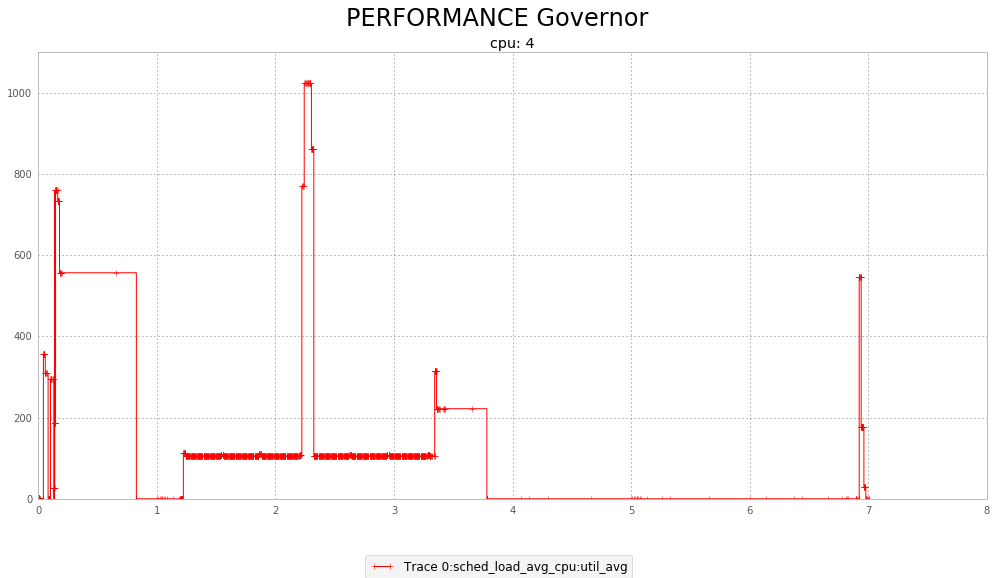

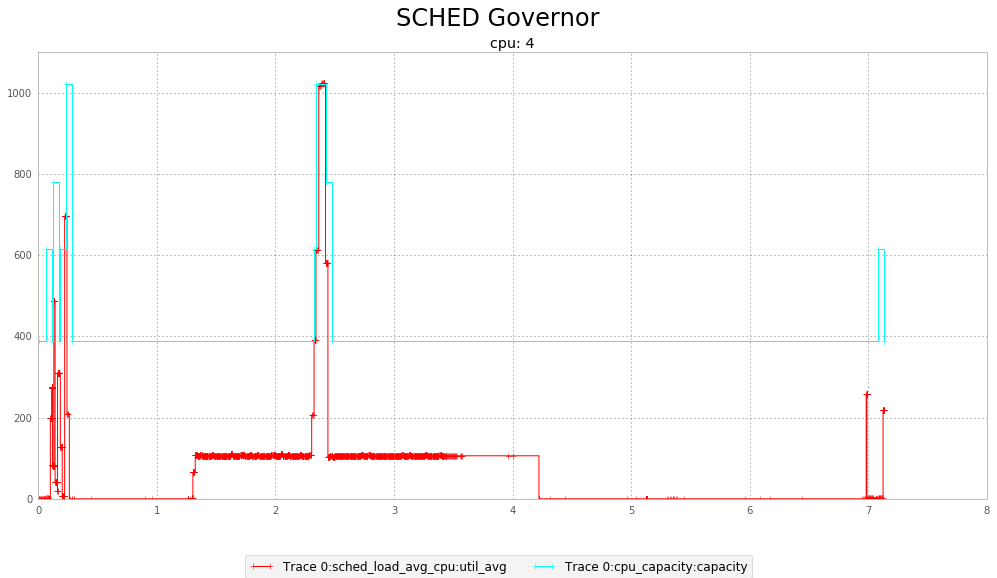

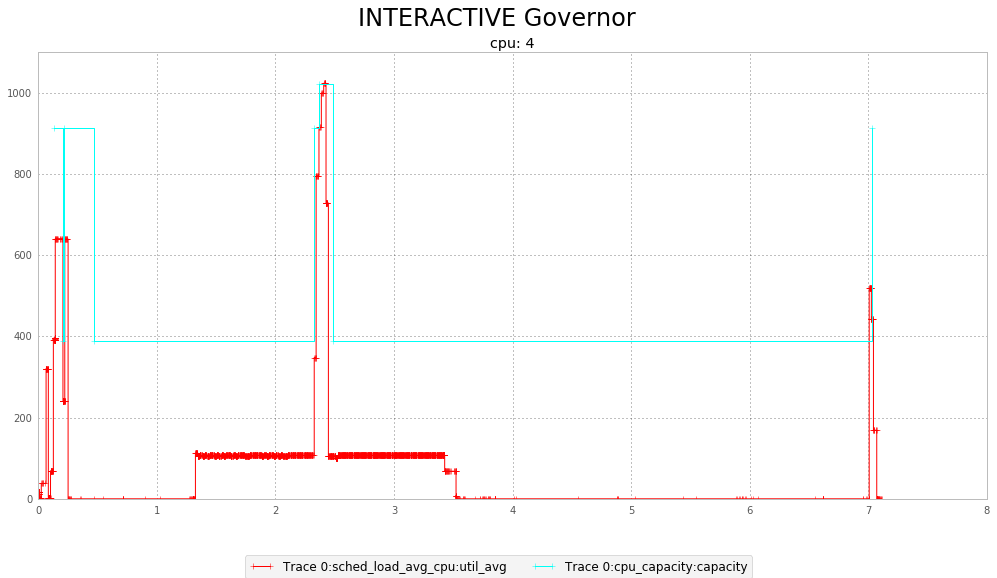

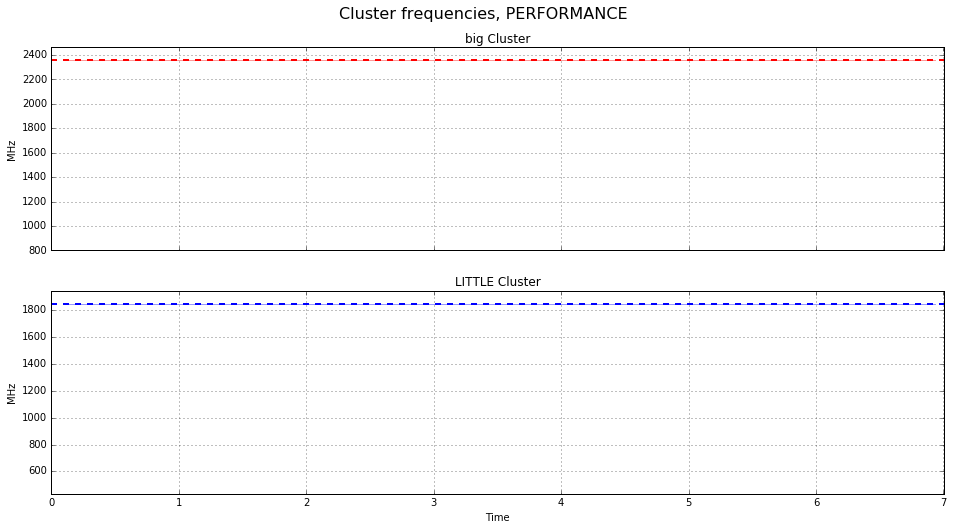

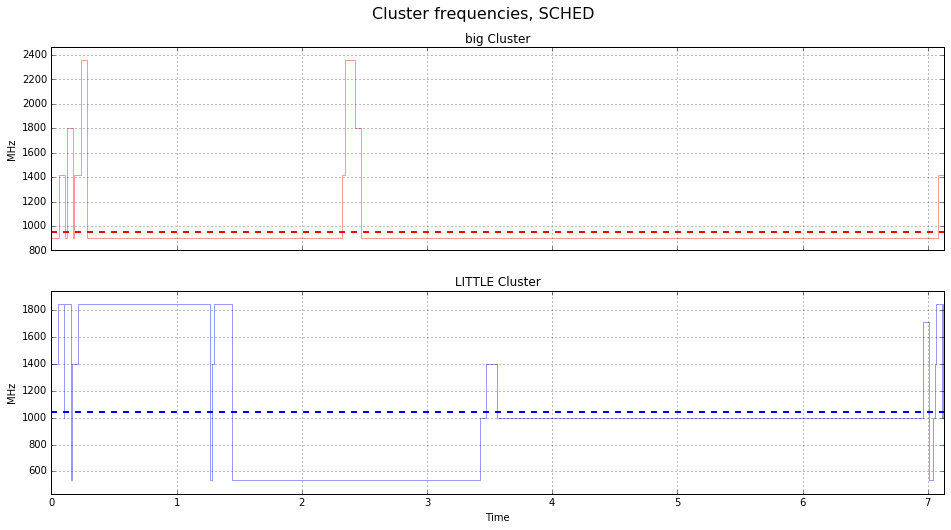

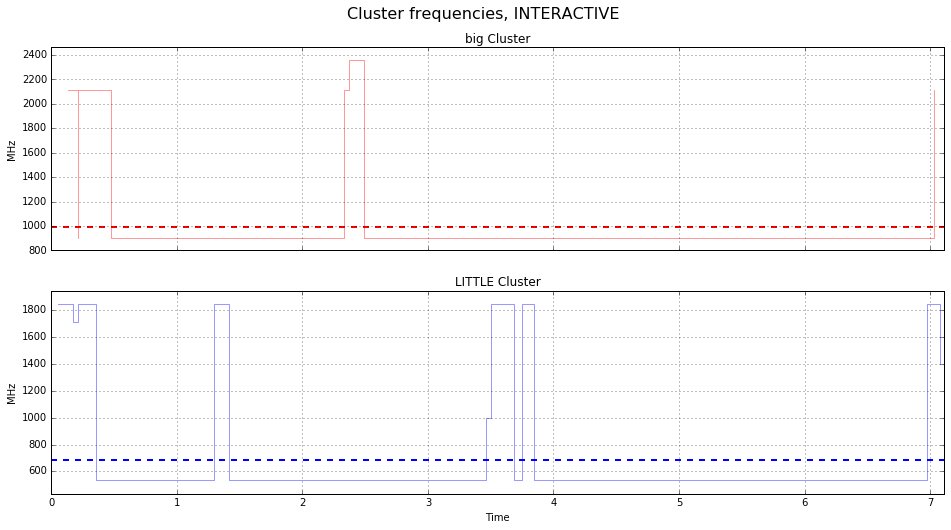

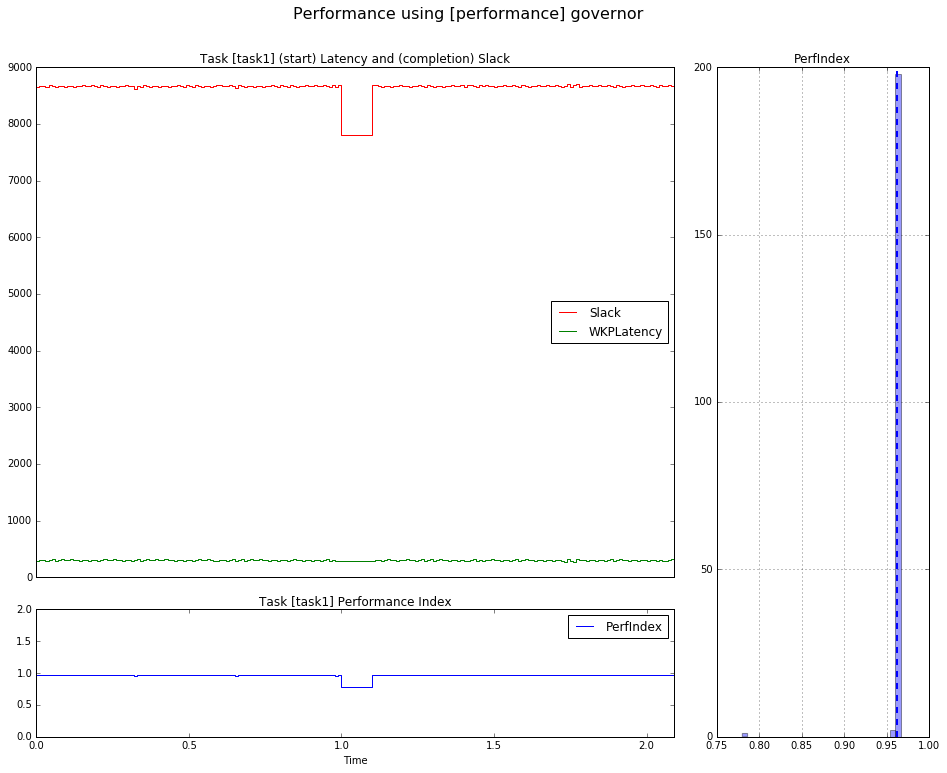

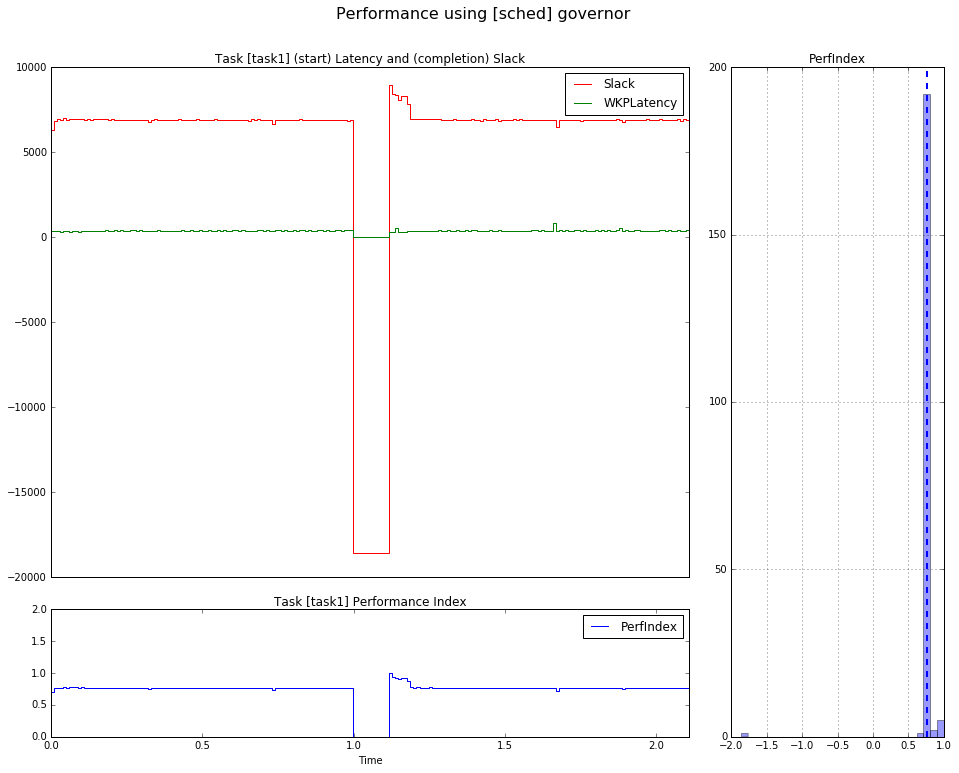

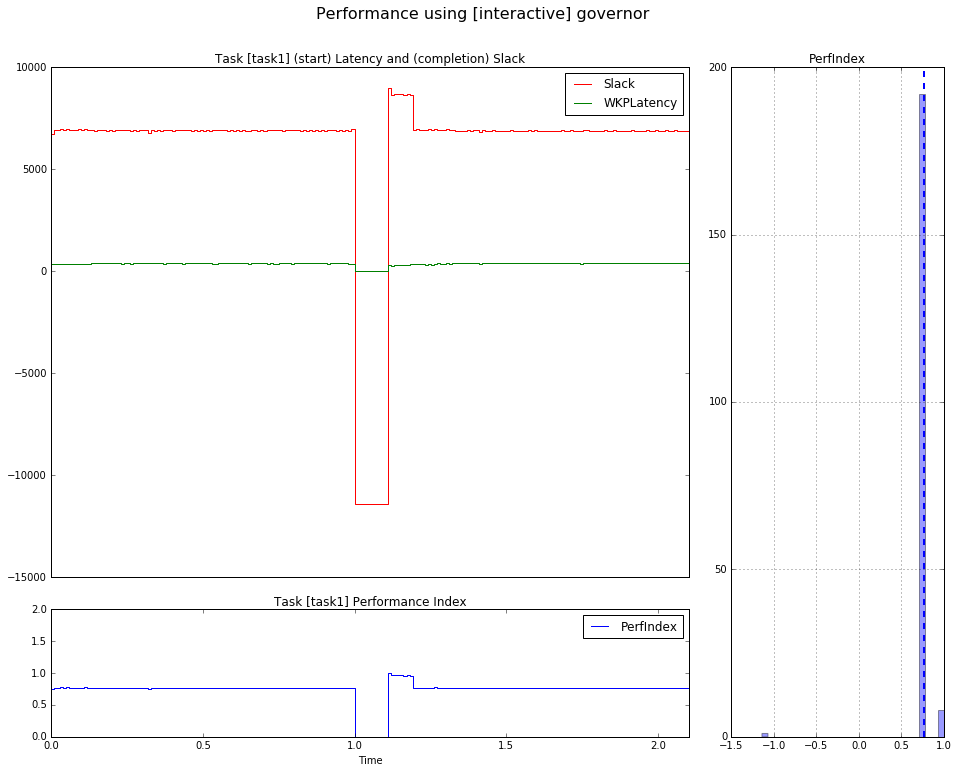

In [14]:
plot(test_case)

In [15]:
report_nrg(test_case)

Governor        |      Total
----------------+------------------------------
performance     |  17921.710
sched           |  13800.880
interactive     |  13285.090


# Test: light/heavy/medium

In [16]:
# Define a label for this test case
test_case = 'light-heavy-medium'

light1 = Periodic(duty_cycle_pct=10, duration_s=1.0, period_ms= 10,
                  cpus=str(target.bl.bigs_online[0]))
heavy1 = Periodic(duty_cycle_pct=90, duration_s=0.1, period_ms=100)
mdium1 = Periodic(duty_cycle_pct=50, duration_s=1.0, period_ms= 10)

lhm_task = light1 + heavy1 + mdium1

rtapp = RTA(target, 'smoke', calibration=te.calibration())
rtapp.conf(
    kind='profile',
    params={
        'task1' : lhm_task.get()
    },
    run_dir=target.working_directory
);



2017-09-05 15:11:09,849 INFO    : Workload     : Setup new workload smoke
2017-09-05 15:11:09,895 INFO    : Workload     : Workload duration defined by longest task
2017-09-05 15:11:09,897 INFO    : Workload     : Default policy: SCHED_OTHER
2017-09-05 15:11:09,898 INFO    : Workload     : ------------------------
2017-09-05 15:11:09,899 INFO    : Workload     : task [task1], sched: using default policy
2017-09-05 15:11:09,900 INFO    : Workload     :  | loops count: 1
2017-09-05 15:11:09,902 INFO    : Workload     :  | CPUs affinity: 4
2017-09-05 15:11:09,903 INFO    : Workload     : + phase_000001: duration 1.000000 [s] (100 loops)
2017-09-05 15:11:09,904 INFO    : Workload     : |  period    10000 [us], duty_cycle  10 %
2017-09-05 15:11:09,906 INFO    : Workload     : |  run_time   1000 [us], sleep_time   9000 [us]
2017-09-05 15:11:09,907 INFO    : Workload     : + phase_000002: duration 0.100000 [s] (1 loops)
2017-09-05 15:11:09,907 INFO    : Workload     : |  period   100000 [us],

In [17]:
# Run this workload in all the configurations
compare(test_case, rtapp)

2017-09-05 15:11:11,592 INFO    : root         : Test case: light-heavy-medium
2017-09-05 15:11:11,597 INFO    : root         :   results folder: /home/lisa/lisa-github/results/20170905_150324/light-heavy-medium
2017-09-05 15:11:11,612 INFO    : root         : ------------------------
2017-09-05 15:11:11,614 INFO    : root         : Run workload using performance governor


2017-09-05 15:11:14,938 INFO    : Workload     : Workload execution START:
2017-09-05 15:11:14,939 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/smoke_00.json 2>&1
2017-09-05 15:11:20,798 INFO    : root         : Energy: {'Device1': 18168.86, 'Device0': 0.0}
2017-09-05 15:11:23,026 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2017-09-05 15:11:23,044 INFO    : root         : ------------------------
2017-09-05 15:11:23,046 INFO    : root         : Run workload using sched governor


2017-09-05 15:11:26,860 INFO    : Workload     : Workload execution START:
2017-09-05 15:11:26,862 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/smoke_00.json 2>&1
2017-09-05 15:11:32,792 INFO    : root         : Energy: {'Device1': 16200.44, 'Device0': 0.0}
2017-09-05 15:11:35,306 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2017-09-05 15:11:35,321 INFO    : root         : ------------------------
2017-09-05 15:11:35,322 INFO    : root         : Run workload using interactive governor


2017-09-05 15:11:38,876 INFO    : Workload     : Workload execution START:
2017-09-05 15:11:38,877 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/smoke_00.json 2>&1
2017-09-05 15:11:44,759 INFO    : root         : Energy: {'Device1': 13411.18, 'Device0': 0.0}
2017-09-05 15:11:46,999 INFO    : Trace        : Platform clusters verified to be Frequency coherent


2017-09-05 15:12:35,812 INFO    : root         : Cluster frequencies, PERFORMANCE:
2017-09-05 15:12:35,975 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-09-05 15:12:36,010 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-09-05 15:12:36,442 INFO    : Analysis     : LITTLE cluster average frequency: 1.844 GHz
2017-09-05 15:12:36,443 INFO    : Analysis     : big    cluster average frequency: 2.362 GHz
2017-09-05 15:12:36,444 INFO    : root         : Cluster frequencies, SCHED:
2017-09-05 15:12:36,608 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-09-05 15:12:36,645 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-09-05 15:12:37,077 INFO    : Analysis     : LITTLE cluster average frequency: 0.976 GHz
2017-09-05 15:12:37,078 INFO    : Analysis     : big    cluster average frequency: 1.495 GHz
2017-09-05 15:12:37,080 INFO    : root         : Cluster fre

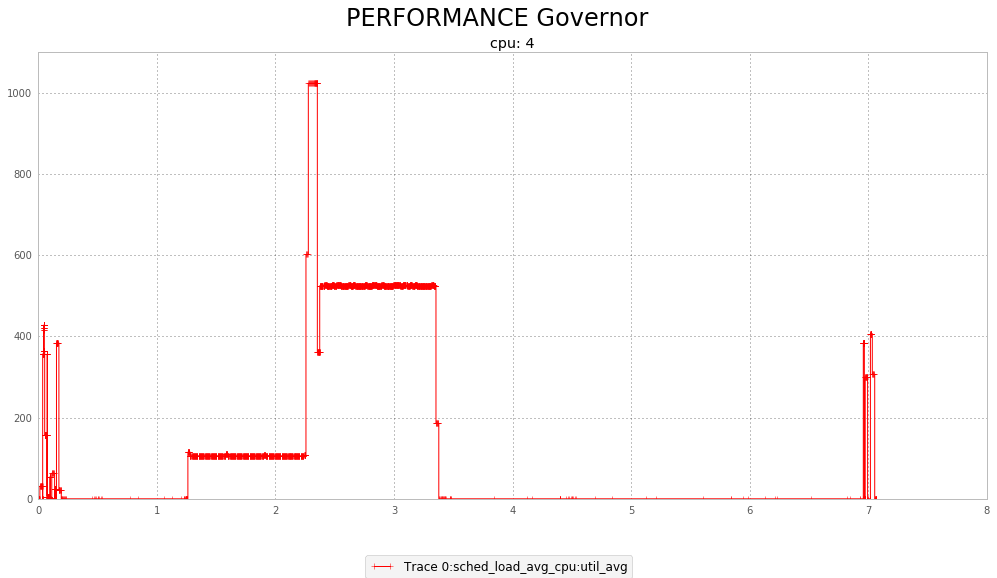

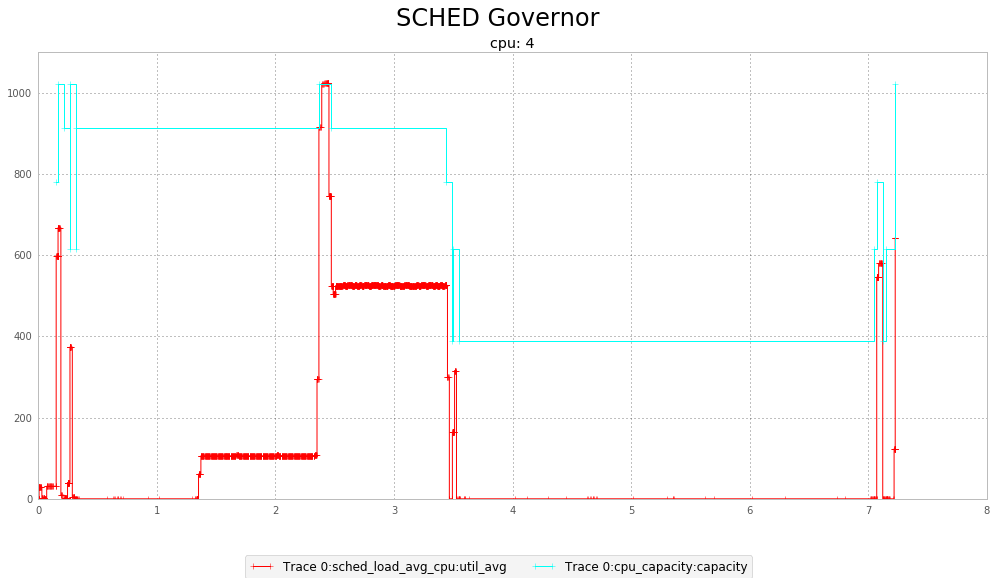

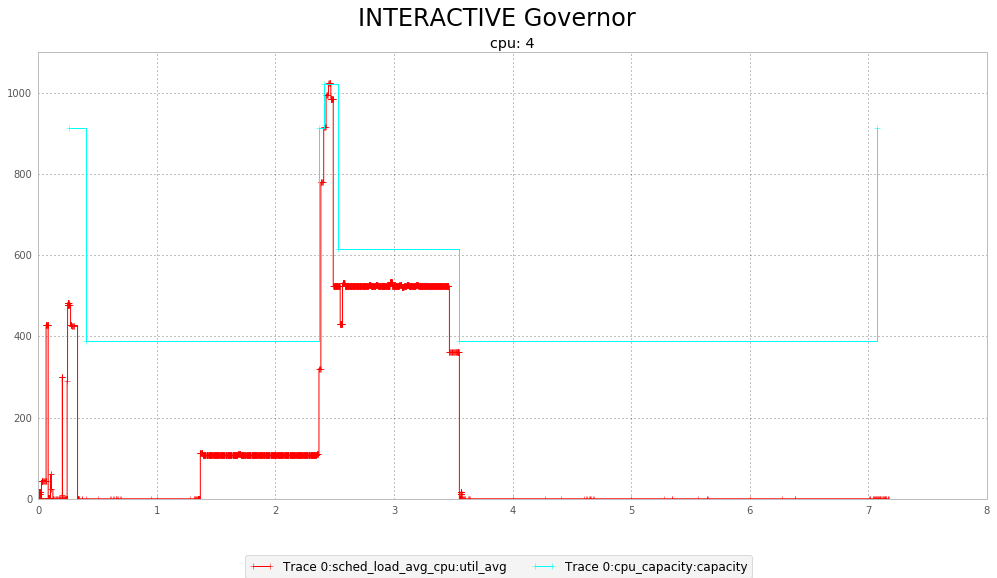

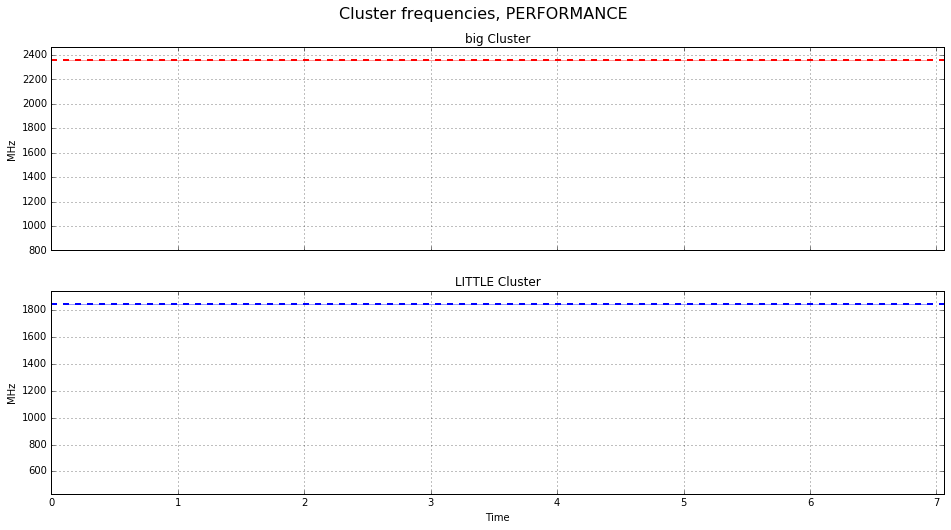

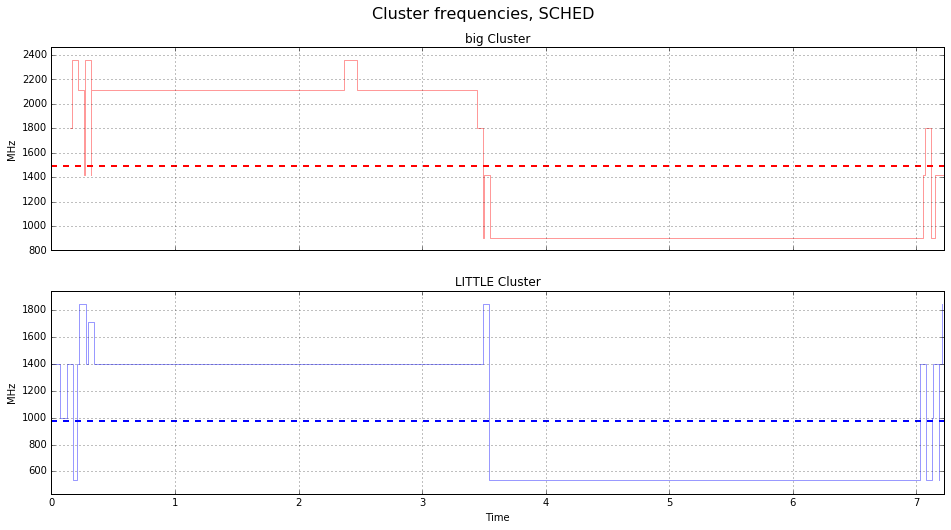

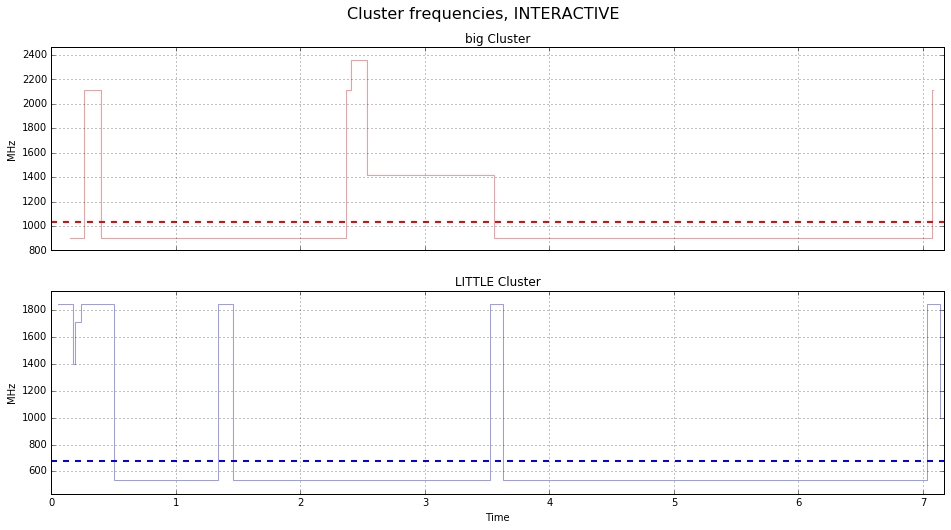

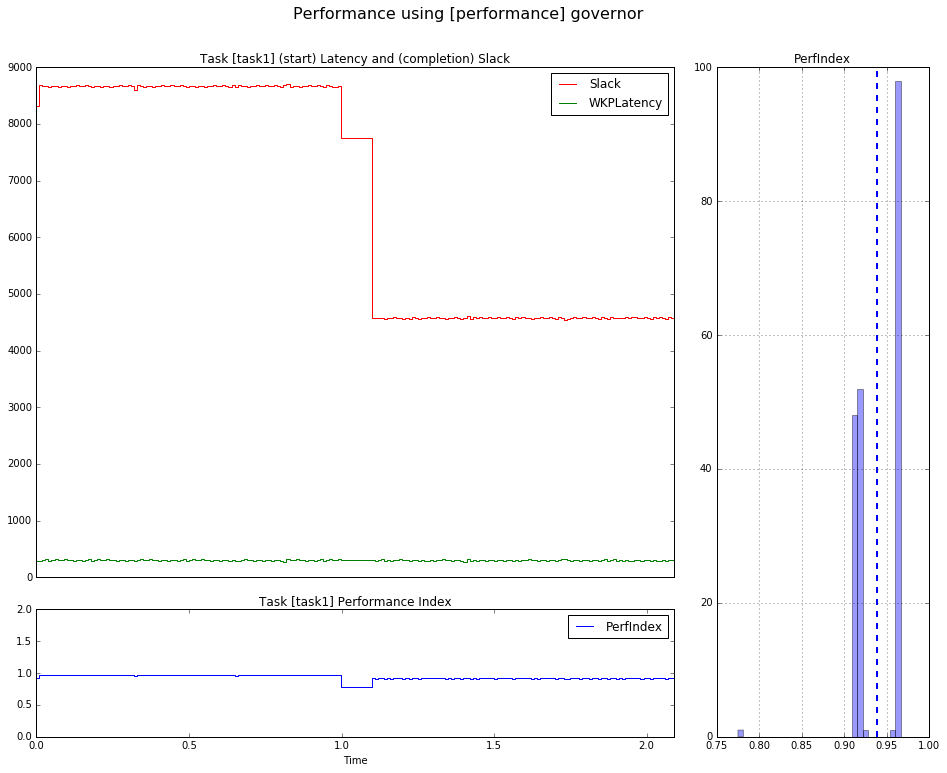

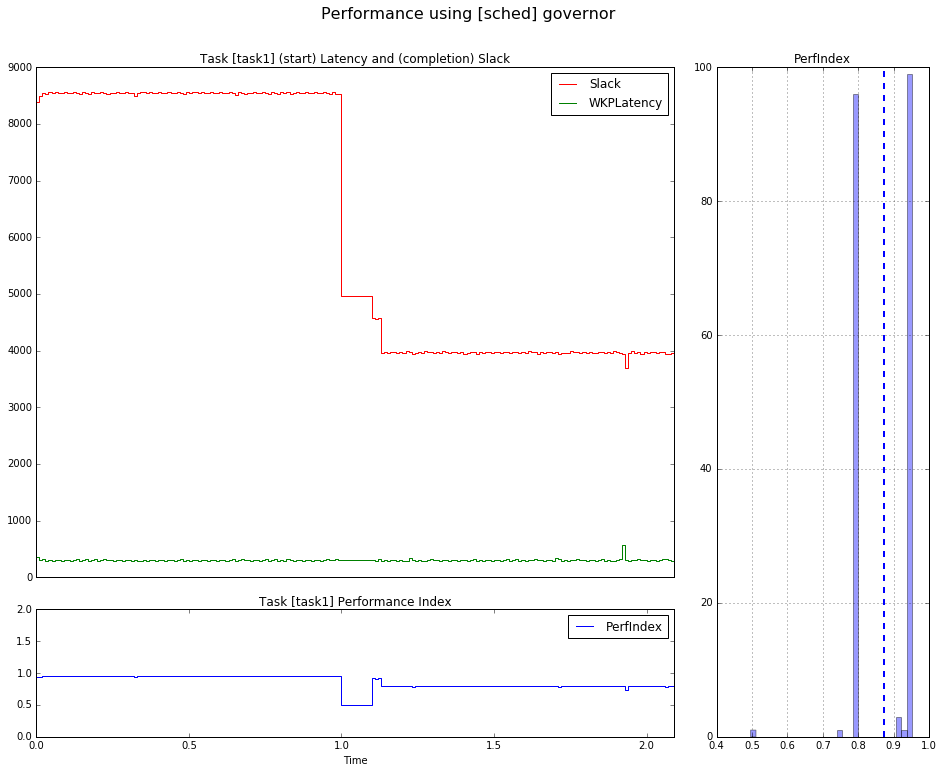

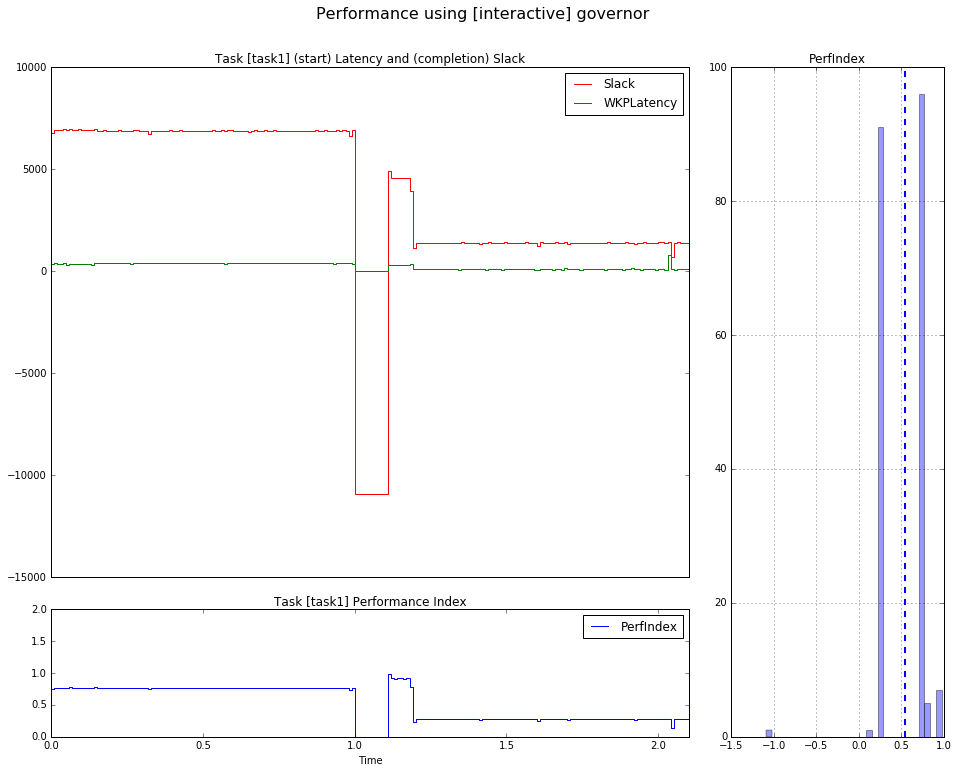

In [18]:
plot(test_case)

In [19]:
report_nrg(test_case)

Governor        |      Total
----------------+------------------------------
performance     |  18168.860
sched           |  16200.440
interactive     |  13411.180
